In [52]:
import csv
from functools import reduce
from collections import Counter

CLASSES = "../OpenImage/class-descriptions-boxable.csv"
LABELS = "../OpenImage/train-annotations-bbox.csv"

In [42]:
# MID to Class 
MID2Class = {}
Class_count = {}
with open(CLASSES, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        MID2Class[row[0]] = row[1]
        Class_count[row[1]] = 0

In [43]:
from pprint import pprint
# pprint(MID2Class)

In [44]:
# Stat MID in Annotations
COUNT = 0
raw_bboxes = []
with open(LABELS, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    first = True
    for row in spamreader:
        if first:
            pprint(row)
            first = not first
            continue
        COUNT -= 1
        if COUNT == 0:
            break
        Class_count[MID2Class[row[2]]] += 1
        raw_bboxes.append(row)
-COUNT

['ImageID',
 'Source',
 'LabelName',
 'Confidence',
 'XMin',
 'XMax',
 'YMin',
 'YMax',
 'IsOccluded',
 'IsTruncated',
 'IsGroupOf',
 'IsDepiction',
 'IsInside']


14610229

In [45]:
# pprint(Class_count)
sorted_classes = sorted(Class_count.items(), key=lambda x:x[1], reverse=True)
# pprint(sorted_classes)

## Raw Count

In [39]:
print('       name             | count')
print('-'*32)
for c in sorted_classes: 
    print('{c[0]:20}     | {c[1]}'.format(c=c))

       name             | count
--------------------------------
Clothing                 | 1438128
Man                      | 1418594
Tree                     | 1051344
Human face               | 1037710
Person                   | 1034721
Woman                    | 767337
Footwear                 | 744474
Window                   | 503467
Flower                   | 345296
Wheel                    | 340639
Plant                    | 267913
Car                      | 248075
Human hair               | 234057
Human arm                | 208982
Human head               | 201633
Girl                     | 197155
Building                 | 178634
Human body               | 175244
Mammal                   | 156154
House                    | 136152
Chair                    | 132483
Tire                     | 122615
Suit                     | 110848
Fashion accessory        | 91024
Food                     | 88422
Boy                      | 87555
Table                    | 85691
Skyscraper      

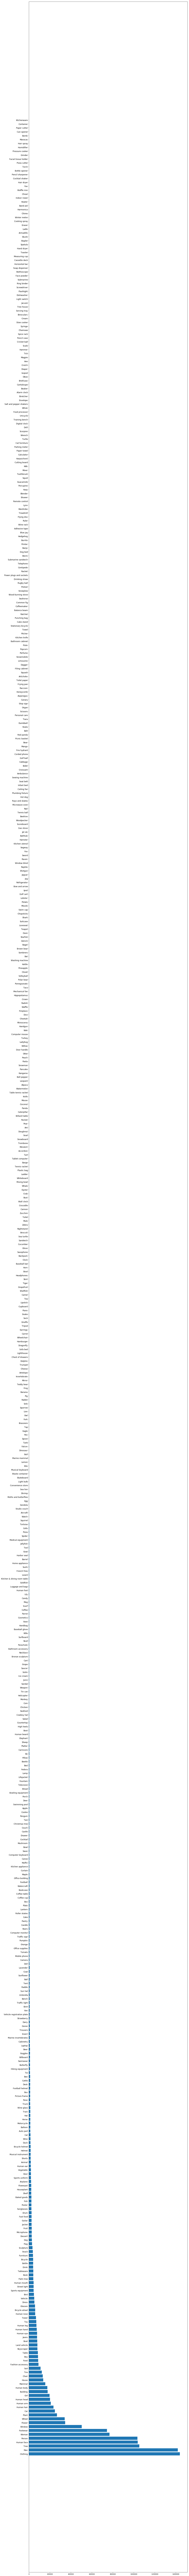

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(18,300))
plt.barh(range(len(sorted_classes)), [x[1] for x in sorted_classes])
plt.yticks(range(len(sorted_classes)), [x[0] for x in sorted_classes], fontsize="large")

plt.show()

In [47]:
pprint(raw_bboxes[:5])

[['000002b66c9c498e',
  'xclick',
  '/m/01g317',
  '1',
  '0.012500',
  '0.195312',
  '0.148438',
  '0.587500',
  '0',
  '1',
  '0',
  '0',
  '0'],
 ['000002b66c9c498e',
  'xclick',
  '/m/01g317',
  '1',
  '0.025000',
  '0.276563',
  '0.714063',
  '0.948438',
  '0',
  '1',
  '0',
  '0',
  '0'],
 ['000002b66c9c498e',
  'xclick',
  '/m/01g317',
  '1',
  '0.151562',
  '0.310937',
  '0.198437',
  '0.590625',
  '1',
  '0',
  '0',
  '0',
  '0'],
 ['000002b66c9c498e',
  'xclick',
  '/m/01g317',
  '1',
  '0.256250',
  '0.429688',
  '0.651563',
  '0.925000',
  '1',
  '0',
  '0',
  '0',
  '0'],
 ['000002b66c9c498e',
  'xclick',
  '/m/01g317',
  '1',
  '0.257812',
  '0.346875',
  '0.235938',
  '0.385938',
  '1',
  '0',
  '0',
  '0',
  '0']]


In [49]:
img2cats = dict()  # a dict (img_id -> a set of category ids)
_ = [img2cats.setdefault(anno[0], set()).add(anno[2]) for anno in raw_bboxes]
cooc_per_img = [list(v) for v in img2cats.values()]

In [50]:
pprint(cooc_per_img[:5])

[['/m/0284d', '/m/0fszt', '/m/04bcr3', '/m/01g317', '/m/0hnyx'],
 ['/m/0d4v4', '/m/0cgh4'],
 ['/m/03bt1vf'],
 ['/m/0pg52', '/m/0cgh4', '/m/0k4j'],
 ['/m/01n4qj',
  '/m/014sv8',
  '/m/0dzct',
  '/m/04hgtk',
  '/m/0dzf4',
  '/m/0jyfg',
  '/m/03q69',
  '/m/0k65p',
  '/m/0283dt1',
  '/m/04yx4',
  '/m/039xj_']]


In [ ]:
cnts = Counter(reduce(lambda x, y: x+y, cooc_per_img))


In [54]:
cats = [(cat_id, cat_name, cnts[cat_id]) for cat_id,cat_name in list(MID2Class.items())]
cat_id_to_idx = dict([(cat_id, idx) for idx,(cat_id,cat_name) in enumerate(MID2Class.items())])


In [62]:
import pickle
cnt_file = open("openimage_train_cnt.pk", "wb")
pickle.dump(cnts, cnt_file)

In [68]:
cooc_mat = [[0] * len(cats) for _ in range(len(cats))]
for cooc in cooc_per_img:
    for i in range(len(cooc) - 1):
        for j in range(i+1, len(cooc)):
            cooc_mat[cat_id_to_idx[cooc[i]]][cat_id_to_idx[cooc[j]]] += 1
            cooc_mat[cat_id_to_idx[cooc[j]]][cat_id_to_idx[cooc[i]]] += 1

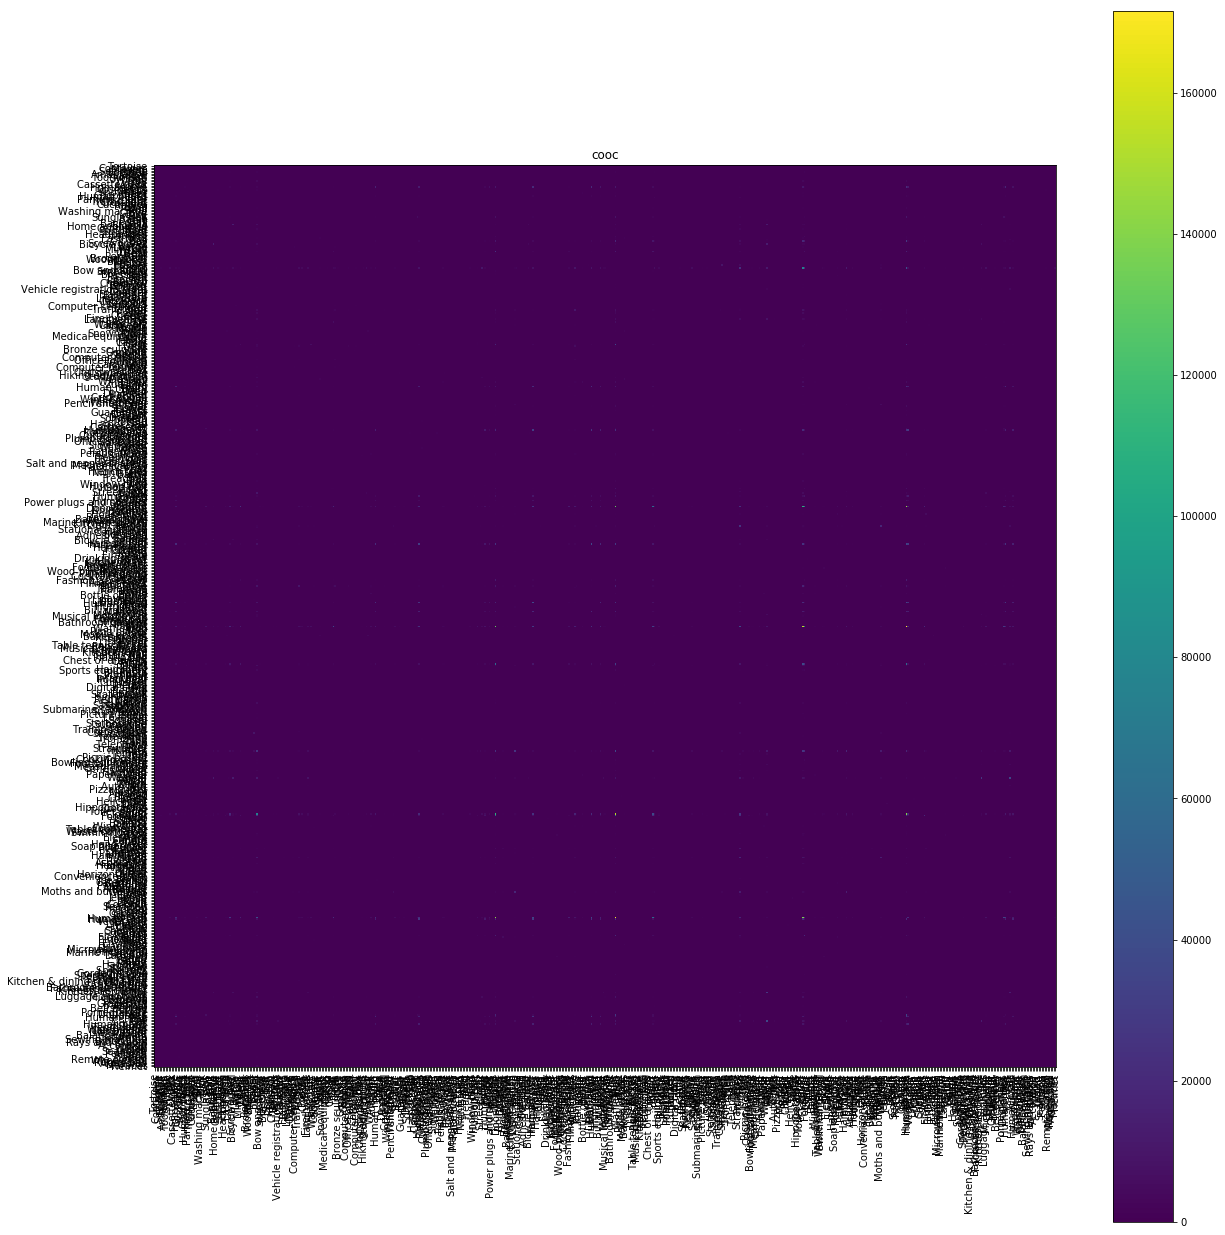

In [69]:
import numpy as np
import matplotlib.pyplot as plt

cooc_mats = np.array(cooc_mat)
plt.figure(figsize=(18,18))
plt.imshow(cooc_mats, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("cooc")
tick_marks = range(len(cats))
plt.xticks(tick_marks, [cat[1] for cat in cats], rotation=90, fontsize='medium')
plt.yticks(tick_marks, [cat[1] for cat in cats], fontsize='medium')
plt.tight_layout()
plt.show()

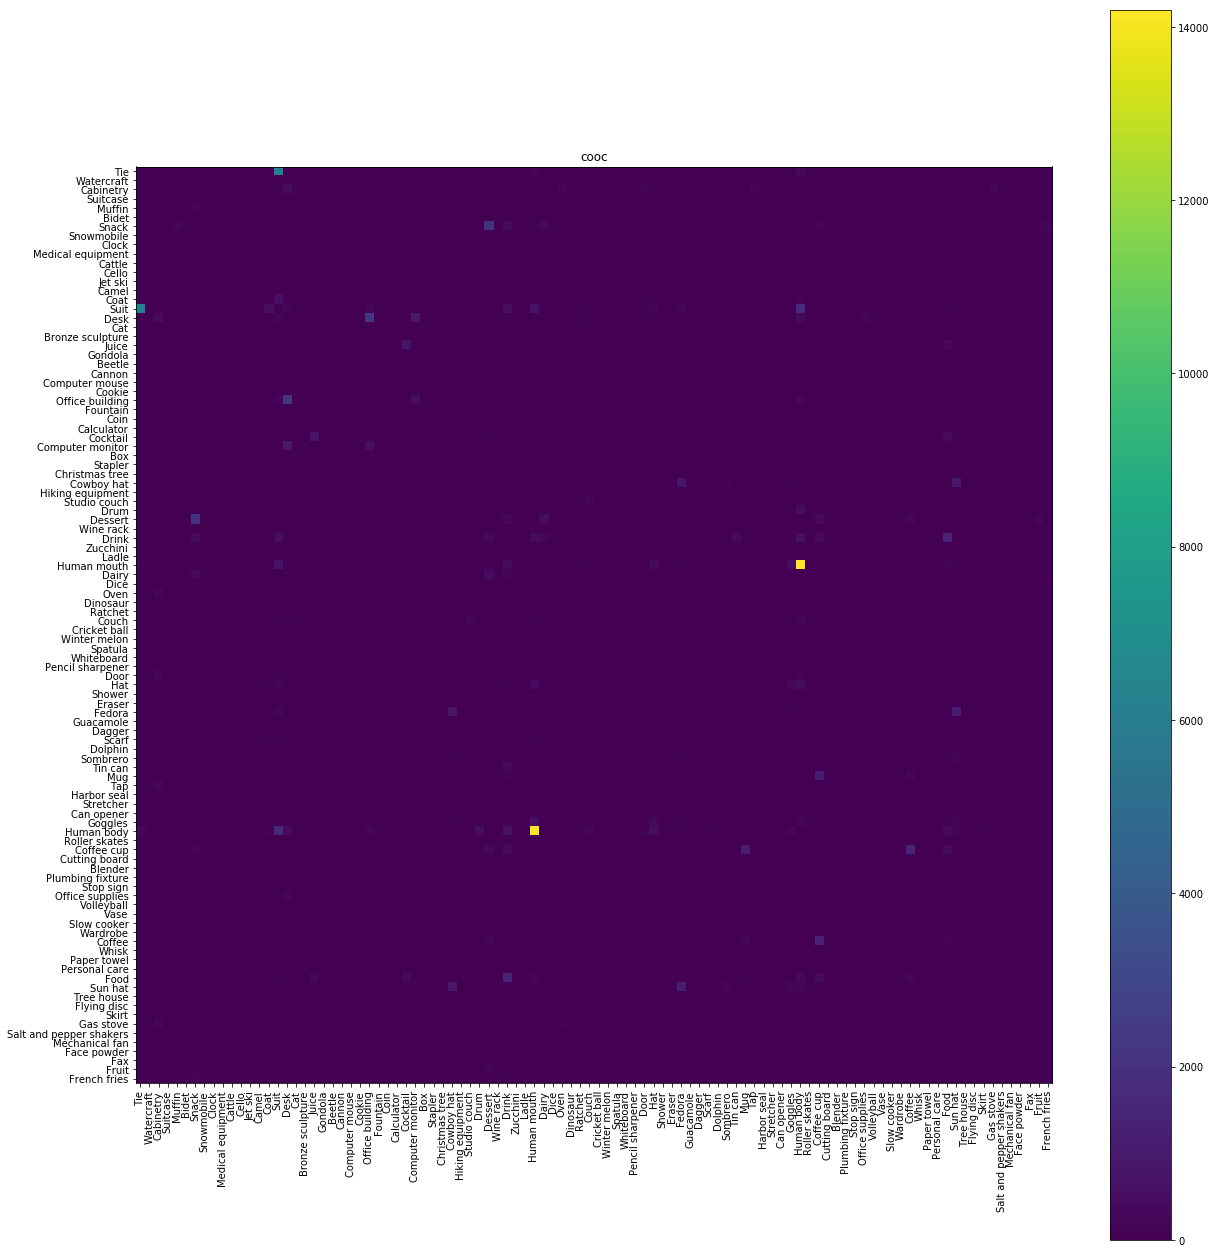

In [74]:
import numpy as np
import matplotlib.pyplot as plt

CAT_START_IDX = 104
SIZE = CAT_START_IDX +100

cooc_mats = np.array(cooc_mat)
cooc_mats = cooc_mats[CAT_START_IDX:SIZE,CAT_START_IDX:SIZE]
plt.figure(figsize=(18,18))
plt.imshow(cooc_mats, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("cooc")
tick_marks = range(len(cats[CAT_START_IDX:SIZE]))
plt.xticks(tick_marks, [cat[1] for cat in cats[CAT_START_IDX:SIZE]], rotation=90, fontsize='medium')
plt.yticks(tick_marks, [cat[1] for cat in cats[CAT_START_IDX:SIZE]], fontsize='medium')
plt.tight_layout()
plt.show()

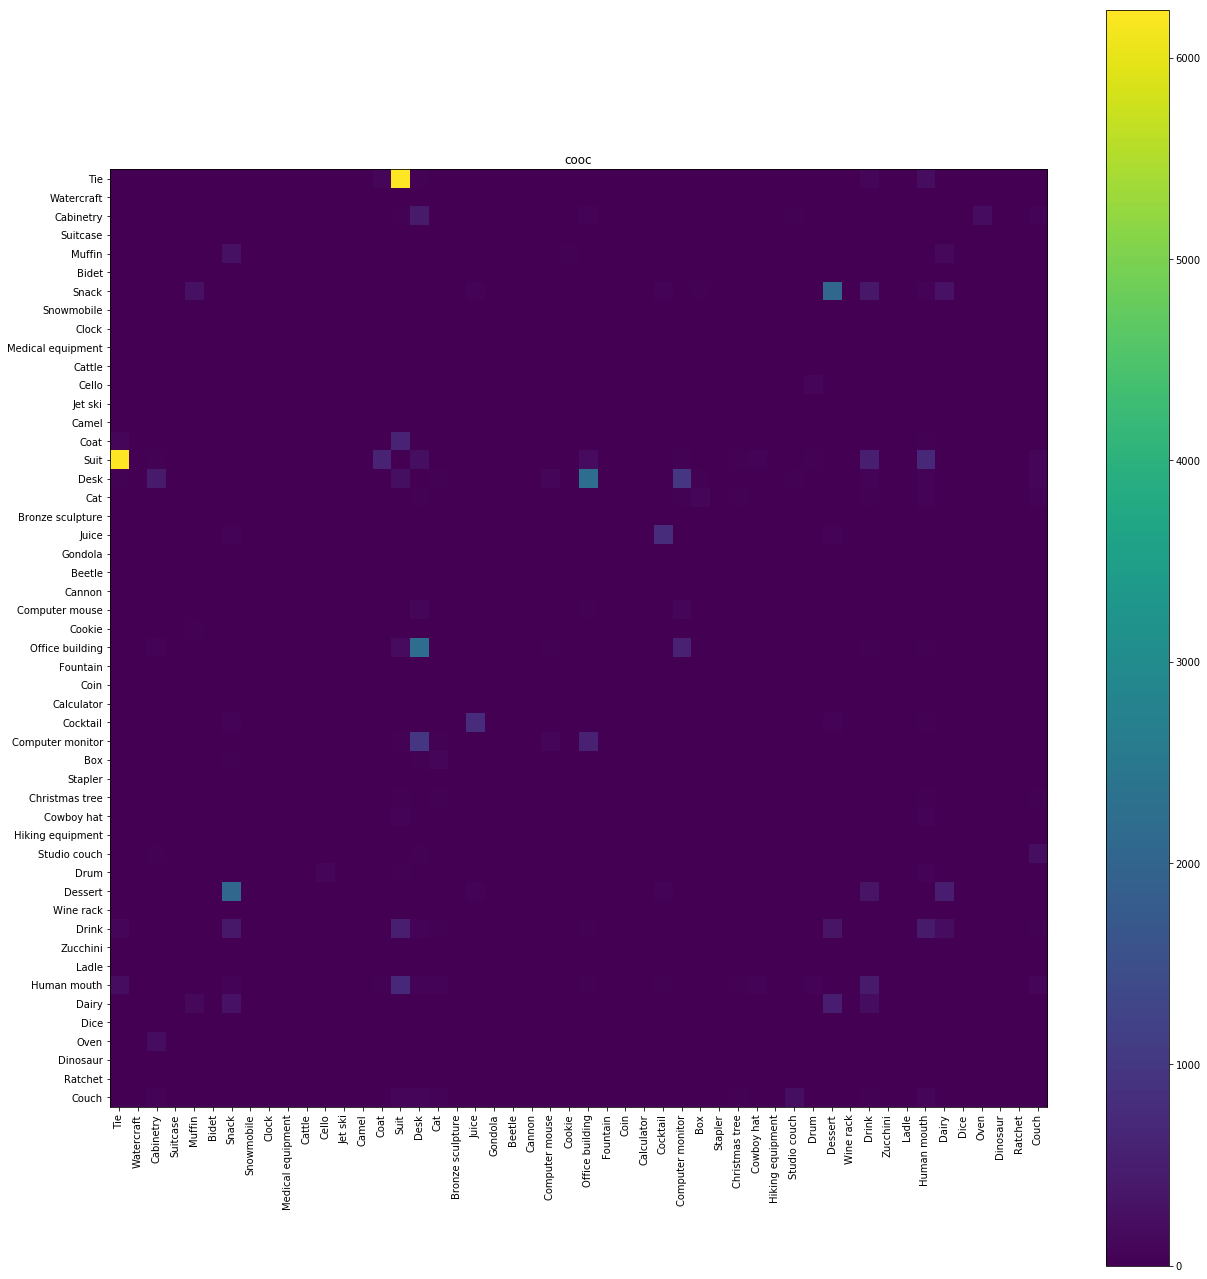

In [75]:
import numpy as np
import matplotlib.pyplot as plt

CAT_START_IDX = 104
SIZE = CAT_START_IDX +50

cooc_mats = np.array(cooc_mat)
cooc_mats = cooc_mats[CAT_START_IDX:SIZE,CAT_START_IDX:SIZE]
plt.figure(figsize=(18,18))
plt.imshow(cooc_mats, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("cooc")
tick_marks = range(len(cats[CAT_START_IDX:SIZE]))
plt.xticks(tick_marks, [cat[1] for cat in cats[CAT_START_IDX:SIZE]], rotation=90, fontsize='medium')
plt.yticks(tick_marks, [cat[1] for cat in cats[CAT_START_IDX:SIZE]], fontsize='medium')
plt.tight_layout()
plt.show()

<Figure size 1080x1080 with 0 Axes>

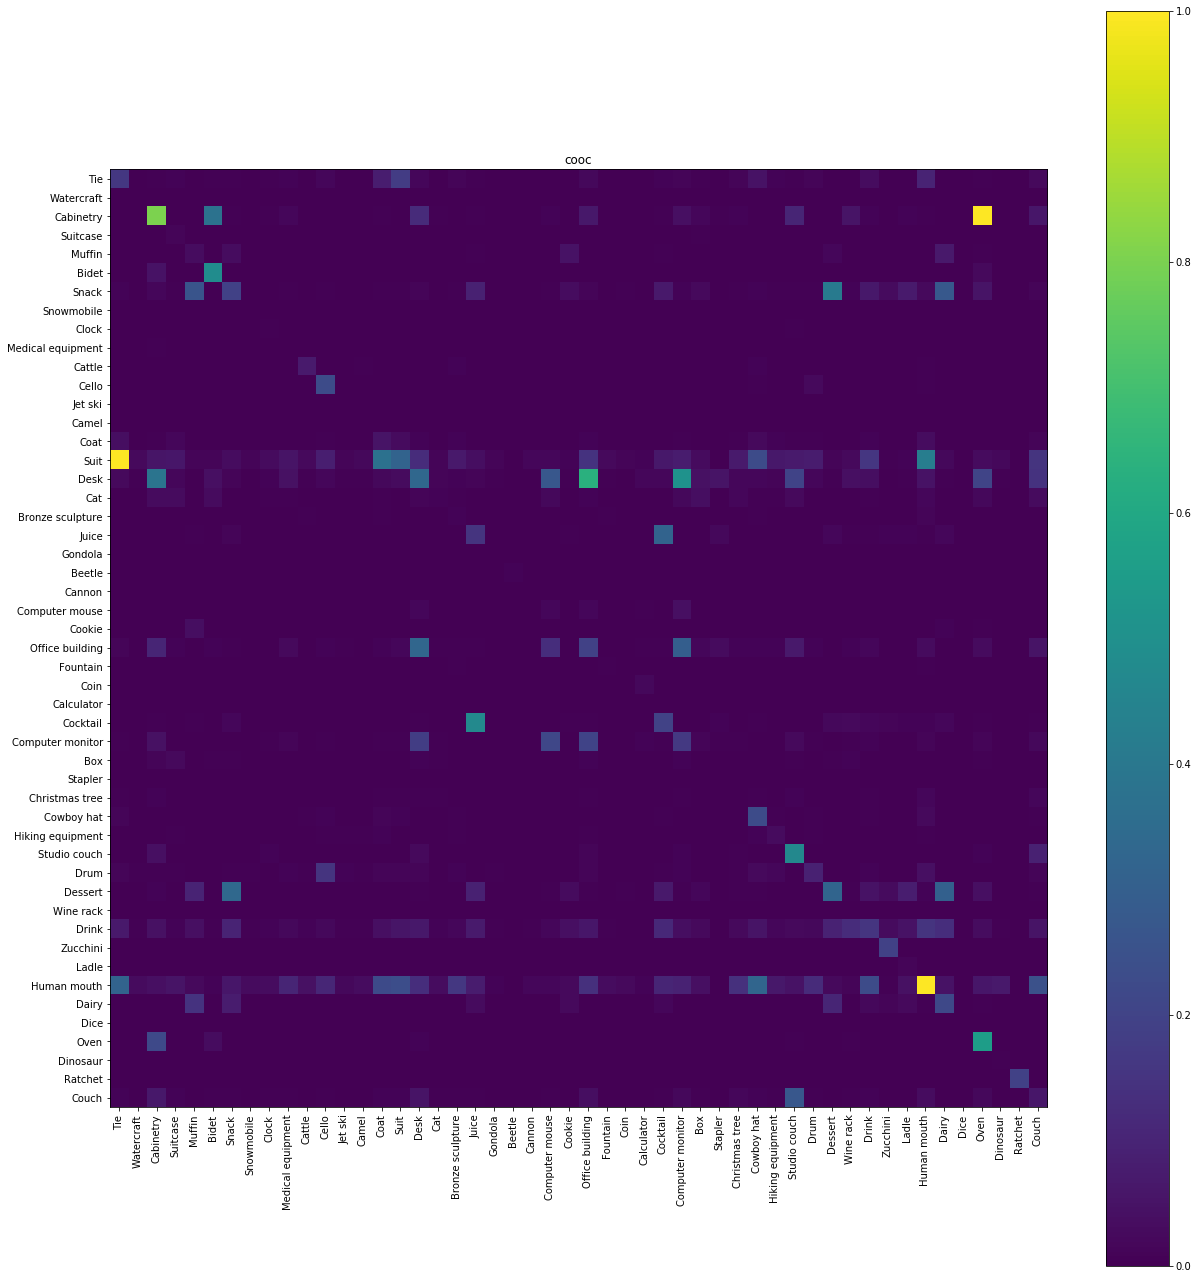

In [78]:
plt.figure(figsize=(15,15))
cond = cooc_mat / np.reshape([c[2]+1 for c in cats], (1, -1))
max_hops = 2
cond_multihop = cond
for h in range(1, max_hops):
    cond_multihop += np.minimum(np.matmul(cond_multihop, cond), 1.0)
    cond_multihop = np.minimum(cond_multihop, 1.0)
# show_cooc_mat(cond_multihop, categories, title='P(y|x) allowing one hop (not formally defined)')

cooc_mats = cond_multihop
cooc_mats = cooc_mats[CAT_START_IDX:SIZE,CAT_START_IDX:SIZE]
plt.figure(figsize=(18,18))
plt.imshow(cooc_mats, cmap=plt.cm.viridis)
plt.colorbar()
plt.title("cooc")
tick_marks = range(len(cats[CAT_START_IDX:SIZE]))
plt.xticks(tick_marks, [cat[1] for cat in cats[CAT_START_IDX:SIZE]], rotation=90, fontsize='medium')
plt.yticks(tick_marks, [cat[1] for cat in cats[CAT_START_IDX:SIZE]], fontsize='medium')
plt.tight_layout()
plt.show()